In [1]:
import h5py
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras


from physionet_processing import (fetch_h5data, spectrogram, 
                                  special_parameters, transformed_stats)

from physionet_processing import (zero_filter, extend_ts, 
                                  random_resample, spectrogram, norm_float)


In [10]:
# mac 
hd_file = "/Users/macbookpro/Documents/physio.h5"
label_file = "/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/REFERENCE-v3.csv"
h5file =  h5py.File(hd_file, 'r')

In [20]:
# Open hdf5 file


# Get a list of dataset names 
dataset_list = list(h5file.keys())

# Load the labels
label_df = pd.read_csv(label_file, header = None, names = ['name', 'label'])
# Filter the labels that are in the small demo set
label_df = label_df[label_df['name'].isin(dataset_list)]


# Encode labels to integer numbers
label_set = list(sorted(label_df.label.unique()))
encoder = LabelEncoder().fit(label_set)
label_set_codings = encoder.transform(label_set)
label_df = label_df.assign(encoded = encoder.transform(label_df.label))
labels = dict(zip(label_df.name, label_df.encoded))
"""

# Split the IDs in training and validation set
test_split = 0.44
idx = np.arange(label_df.shape[0])
id_train, id_val, _, _ = train_test_split(idx, idx, 
                                        test_size = test_split,
                                        shuffle = True,
                                        random_state = 123)
val_split = 0.3
id_val, id_test, _ , _ = train_test_split(id_val, id_val, 
                                        test_size = val_split,
                                        shuffle = True,
                                        random_state = 123)
# Store the ids and labels in dictionaries
partition = {'train': list(label_df.iloc[id_train,].name), 
            'validation': list(label_df.iloc[id_val,].name), 
            'test': list(label_df.iloc[id_test,].name)}


print(len(partition['train']))
print(len(partition['validation']))
print(len(partition['test']))
"""


"\n\n# Split the IDs in training and validation set\ntest_split = 0.44\nidx = np.arange(label_df.shape[0])\nid_train, id_val, _, _ = train_test_split(idx, idx, \n                                        test_size = test_split,\n                                        shuffle = True,\n                                        random_state = 123)\nval_split = 0.3\nid_val, id_test, _ , _ = train_test_split(id_val, id_val, \n                                        test_size = val_split,\n                                        shuffle = True,\n                                        random_state = 123)\n# Store the ids and labels in dictionaries\npartition = {'train': list(label_df.iloc[id_train,].name), \n            'validation': list(label_df.iloc[id_val,].name), \n            'test': list(label_df.iloc[id_test,].name)}\n\n\nprint(len(partition['train']))\nprint(len(partition['validation']))\nprint(len(partition['test']))\n"

In [7]:


with open("/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_keras_tflites/cnn_small_9_testlabel.pcl", "rb") as f:
    test_labels = pickle.load(f)

In [18]:
max_length = 18286

# Output dimensions
sequence_length = max_length
spectrogram_nperseg = 64 # Spectrogram window
spectrogram_noverlap = 32 # Spectrogram overlap
n_classes = len(label_df.label.unique())
batch_size = 32

# calculate image dimensions
data = fetch_h5data(h5file, [0], sequence_length)
_, _, Sxx = spectrogram(data, nperseg = spectrogram_nperseg, noverlap = spectrogram_noverlap)
dim = Sxx[0].shape




batch_size= batch_size
dim= dim
nperseg= spectrogram_nperseg
noverlap= spectrogram_noverlap
n_channels= 1
sequence_length= sequence_length
n_classes=n_classes
shuffle= True
data_mean = -9.01
data_std = 9.00

In [25]:
# Initialization
augment = False
batch_size = len(test_labels)
X = np.empty((batch_size, *dim, n_channels), dtype = float)
y = np.empty((batch_size), dtype = int)
for i, ID in enumerate(test_labels):
    # if i == 10:
    #     break
    data = extend_ts(h5file[ID]['ecgdata'][:, 0], sequence_length)
    data = np.reshape(data, (1, len(data)))

    if augment:
    
        # dropout bursts
        data = zero_filter(data, threshold = 2, depth = 10)
    
        # random resampling
        data = random_resample(data)
    
    # Generate spectrogram
    data_spectrogram = spectrogram(data, nperseg = nperseg, noverlap = noverlap)[2]
    
    # Normalize
    data_transformed = norm_float(data_spectrogram, data_mean, data_std)

    X[i,] = np.expand_dims(data_transformed, axis = 3)

    # Assuming that the dataset names are unique (only 1 per label)
    y[i] = labels[ID]

X = X.reshape(batch_size,570,-1)
y = keras.utils.to_categorical(y, num_classes=n_classes)

In [30]:
with open("/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/X_test.pcl" ,"wb") as f:
    pickle.dump(X, f)


with open("/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/y_test.pcl", "wb") as f:
    pickle.dump(y, f)


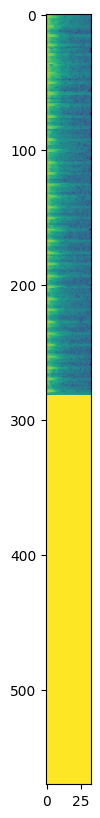

In [27]:
# print( y [1000])
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(X[1000])
plt.show()